## 数据处理
#### 2019-09-19
#### Arthur Pang

- **找到时间不连续数据段** 由于高层建筑覆盖或过隧道等，GPS信号丢失，造成所提供数据中的时间不连续；
- **计算速度差**汽车加、减速度异常的数据（普通轿车一般情况下：0至100km/h的加速时间大于7秒，紧急刹车最大减速度在7.5~8 m/s2）；
- **找无转速无速度点**长期停车（如停车不熄火等候人、停车熄火了但采集设备仍在运行等）所采集的异常数据。
- **找长期低速，设为怠速**长时间堵车、断断续续低速行驶情况（最高车速小于10km/h）,通常可按怠速情况处理。
- **x**一般认为怠速时间超过180秒为异常情况，怠速最长时间可按180秒处理。


In [119]:
import pandas as pd
import datetime
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

class Data_Processing():
    def __init__(self):
        self.data_path='./cpic_data/'
        self.basic_feature=['GPS车速',
                            'X轴加速度',
                            'Y轴加速度',
                            'Z轴加速度',
                            '经度',
                            '纬度',
                            '发动机转速',
                            '扭矩百分比',
                            '瞬时油耗',
                            '油门踏板开度',
                            '空燃比',
                            '发动机负荷百分比',
                            '进气流量']
        self._cols=['format_time',
                    'GPS车速',
                            'X轴加速度',
                            'Y轴加速度',
                            'Z轴加速度',
                            '经度',
                            '纬度',
                            '发动机转速',
                            '扭矩百分比',
                            '瞬时油耗',
                            '油门踏板开度',
                            '空燃比',
                            '发动机负荷百分比',
                            '进气流量']
        
        self.get_days= lambda x:x[:10]
        self.get_secords= lambda x:x[17:19]
    
    ###线性插值
    def interpolate(self,x,y,n):
        res=[]
        delta=(y-x)/n
        for i in range(1,n):
            
            res.append(x+delta)
            x+=delta
        return res
    
    ##计算时间  处理丢失情况
    def cal_time_delta(self,data_file):
        data_1=pd.read_csv(self.data_path+data_file,encoding='utf8')
        data_1['date']=data_1['时间'].apply(self.get_secords)
        #标准格式时间
        data_1['format_time']=pd.to_datetime(data_1['时间'],format="%Y/%m/%d %H:%M:%S.000.")
        #secords_list=data_1['date'].tolist()
        flag=False
        tmp=1
        tmp_t=0
        delta_res=[]
        # 待添加结果
        wait_add_df=pd.DataFrame()
        for _,row in data_1.iterrows():
            if not flag:
                flag=True
                tmp=row['format_time']
                tmp_t=row
                continue
            # 连续短时间丢失  加速度一致 做均加速运动
            if (row['format_time']-tmp).seconds>1 and (row['format_time']-tmp).seconds<10:
                n=(row['format_time']-tmp).seconds
                print(n)
                delta_df=pd.DataFrame()
                delta_df['format_time']=[tmp+datetime.timedelta(seconds=i) for i in range(1,n)]
                for _f in self.basic_feature:
                    if _f==' X轴加速度' or _f=='Y轴加速度' or _f=='Z轴加速度':
                        delta_df[_f]=[(row[_f]+tmp_t[_f])/2 for x in range(1,n)]
                        continue
                        
                    delta_df[_f]=self.interpolate(tmp_t[_f],row[_f],n)
                    
                #print(delta_df)
                wait_add_df=wait_add_df.append(delta_df,ignore_index=True)
                #break  
                #delta_res.append(a)
                
                #pass
                
                #print(pd.DataFrame(row).stack())
                
                #print(tmp_data[self.basic_feature])          
                #break
            tmp=row['format_time']
            tmp_t=row
        #res=pd.DataFrame(delta_res)
        #res.to_csv(self.data_path+'delta_'+data_file,index=None)
        
        data_tmp=data_1[self._cols]
        
        data_tmp=data_tmp.append(wait_add_df,ignore_index=True)
        data_tmp.sort_values(['format_time'],inplace=True)
        data_tmp.to_csv(self.data_path+'filling_'+data_file,index=None)
        return 'filling_'+data_file
        #print(wait_add_df.head())
    ### 删除 异常短时间运动 
    ### v不等于0 且 运动时间小于10s
    ### 运算发现：无该类情况 无需处理 
    def del_records(self,data_file):
        data=pd.read_csv(self.data_path+data_file,encoding='utf8')
        data['format_time']=pd.to_datetime(data['format_time'])
        running_time=data[data['GPS车速']!=0]
        time_windows=10
        _i=0
        begin_flag=False
        head_index=0
        head_i=0
        for _,row in running_time.iterrows():
            if not begin_flag:
                head_index=row['format_time']
                head_i=0
                begin_flag=True
                continue
            time_delta=(row['format_time']-head_index).seconds
            if time_delta>(_-head_i) and (_-head_i)<=10:
                drop_index=[]
                i=0
                while head_i+i<_:
                    drop_index.append(head_i+i)
                    i+=1
                data.drop([head_i],inplace=True)
                print(head_index,row['format_time'])
                #break
            head_index=row['format_time']
            head_i=_
            
            
    def continusFind(self,num_list):
        '''
        列表中连续数字段寻找
        '''
        num_list.sort()
        s=1
        find_list=[]
        have_list=[]
        while s<=len(num_list)-1:
            if (num_list[s]-num_list[s-1]).seconds==1:
                flag=s-1
                try:
                    while (num_list[s]-num_list[s-1]).seconds==1:
                        s+=1
                    #print(num_list[flag:s])
                    find_list.append(num_list[flag:s])
                except:
                    return find_list
            else:
                s+=1
                
        return find_list

        ###  发现堵车低速时段
    ### v不等于0 且 运动时间小于10s
    ### 运算发现：无该类情况 无需处理 
    def find_jam_records(self,data_file):
        data=pd.read_csv(self.data_path+data_file,encoding='utf8')
        data['format_time']=pd.to_datetime(data['format_time'])
        low_speed_time=data[(data['GPS车速']<=10)&( data['GPS车速']>0)]
      
        print(low_speed_time.shape)
        tmp=low_speed_time['format_time'].tolist()
        print(len(tmp))
        res_list=self.continusFind(tmp)
        
        for _,row in low_speed_time.iterrows():
            #_ind=[_-i for i in range(1,6)]
            
            before_data=data.iloc[_-5:_]
            #print(row,before_data)
            
            after_data=data.iloc[_+1:_+11]
            before_counts=before_data['GPS车速'].tolist().count(0)
            #print(row)
            after_counts=after_data['GPS车速'].tolist().count(0)
            if after_data['GPS车速'].max()<=10 and before_counts>=4 and after_counts>=2:
                for i in range(_,_+11):
                    #print(data.loc[i,['GPS车速']])
                    data.loc[i,['GPS车速']]=0
                    #print(data.loc[i,['GPS车速']])
                
           
        data.to_csv(self.data_path+'jam_'+data_file,index=None,encoding='utf8')
        return 'jam_'+data_file
            

        
    
    ### 删除 异常怠速时段 超过180s仅取前180s 
    ### 
    def del_idle_speed_records(self,data_file):
        data=pd.read_csv(self.data_path+data_file,encoding='utf8')
        print('before del idle time :',data.shape[0])
        data['format_time']=pd.to_datetime(data['format_time'])
        idle_time=data[data['GPS车速']==0]
        time_windows=10
        _i=0
        begin_flag=False
        head_index=0
        head_i=0
        #print(idle_time.shape)
        flag=False
        first_index=0
        last_index=0
        index_res=[]
        for _,row in data.iterrows():
            if row['GPS车速']==0:
                if not flag:
                    flag=True
                    first_index=_
            else:
                if flag:
                    last_index=_
                    flag=False
                    index_res.append((first_index,last_index))
        _sum=0
        for (a,b) in index_res:
            
            if b-a>180:
                _sum+=1
                drop_index=[]
                i=0
                while a+180+i<b:
                    drop_index.append(a+180+i)
                    i+=1
                #print(data.shape)
                data.drop(drop_index,inplace=True)
                #print(data.shape)
        print(_sum,len(index_res))
        data.to_csv(self.data_path+'del_'+data_file,index=None,encoding='utf8')
        print('after del idle time :',data.shape[0])
        return 'del_'+data_file
        
              
                    

            
    
    def acc_speed(self,data_file):
        a_data=pd.read_csv(self.data_path+data_file,encoding='utf8')
        print('before del acc time :',a_data.shape[0])
        a_data['format_time']=pd.to_datetime(a_data['format_time'])

        a_data['acc_speed']=0.000000
        head_index=0
      
        _i=0
        begin_flag=False

        head_i=0
        all=a_data.shape[0]

        #print (all)
        acc_res=[]
        test_res=[]
        for i in range(1,all):
            if (a_data['format_time'][i]-a_data['format_time'][i-1]).seconds==1:
                #a_data['加速度'][i-1]=(a_data['GPS车速'][i]-a_data['GPS车速'][i-1])*1000/3600
                acc_res.append((a_data['GPS车速'][i]-a_data['GPS车速'][i-1])*1000/3600)
                
            else:
                #a_data['加速度'][i-1]=a_data['加速度'][i-1]
                acc_res.append(a_data['acc_speed'][i-1])
        acc_res.append(a_data['acc_speed'][i-1])
        a_data['acc_speed']=acc_res
        a_data['test']=[x*3600/1000 for x in acc_res]

        #print(a_data['加速度'])
                       
        #a_data.to_csv(self.data_path+'acc_speed_'+data_file,index=None,encoding='utf8')
        a_data[(a_data['acc_speed']<=6)&(a_data['acc_speed']>=-8)].to_csv(self.data_path+'del_acc_'+data_file,index=None,encoding='utf8')
        print('after del acc time :',a_data[(a_data['acc_speed']<=6)&(a_data['acc_speed']>=-8)].shape[0])
        
        return 'dacc_'+data_file
    
    def idle_time_count(self,data_file):
        data=pd.read_csv(self.data_path+data_file,encoding='utf8')
        data['format_time']=pd.to_datetime(data['format_time'])
        low_speed_time=data[data['GPS车速']==0]
      
        print(low_speed_time.shape)
        tmp=low_speed_time['format_time'].tolist()
        print(len(tmp))
        res_list=self.continusFind(tmp)
        time_records=[]
        for _item in res_list:
            time_records.append(len(_item))
        
                
        ### 怠速时段统计
        pd.DataFrame(time_records).to_csv(self.data_path+'idle_time_count.csv',index=None)
        return 'filling_jam_'+data_file
    
    def csv_compare(self):
        data_1=pd.read_csv(self.data_path+'filling_data_1.csv',encoding='utf8')
        data_2=pd.read_csv(self.data_path+'filling_jam_data_1.csv',encoding='utf8')
        print(data_1.shape)
        print(data_2.shape)
        
        a=data_1['GPS车速'].tolist()
        b=data_2['GPS车速'].tolist()
        delta=0
        for i in range(len(a)):
            if a[i]==b[i]:
                continue
            else:
                delta+=1
        print(delta,delta/data_1.shape[0])
                
            
    
    # 填充长时段缺失
    def filling_long_empty(self,data_file):
        data_1=pd.read_csv(self.data_path+data_file,encoding='utf8')
       
        data_1['format_time']=pd.to_datetime(data_1['format_time'])
        #secords_list=data_1['date'].tolist()
        flag=False
        tmp=1
        tmp_t=0
        delta_res=[]
        # 待添加结果
        wait_add_df=pd.DataFrame()
        for _,row in data_1.iterrows():
            if not flag:
                flag=True
                tmp=row['format_time']
                tmp_t=row
                continue
            # 连续短时间丢失  加速度一致 做均加速运动
            if (row['format_time']-tmp).seconds>1 and (row['format_time']-tmp).seconds<180:
                n=(row['format_time']-tmp).seconds
                
                # 都处于低速空间的情况
                if row['GPS车速']<=10 or tmp_t['GPS车速']<=10:
                    tmp=row['format_time']
                    tmp_t=row
                    continue


                #plt.plot(x,y,marker='*',color='r')
                
                before=data_1.iloc[_-5:_+5]['GPS车速'].tolist()
                
                delta_df=pd.DataFrame()
               
                print(np.array(before).var())
                if  np.array(before).var()<40 and (abs(row['GPS车速']-tmp_t['GPS车速'])<=15):
                    print('当前车速:',row['GPS车速'],'前一个速度',tmp_t['GPS车速'])
                    print('缺失时间',n,row['format_time'],tmp)
                    
                    delta_df['format_time']=[tmp+datetime.timedelta(seconds=i) for i in range(1,n)]
                    for _f in self.basic_feature:
                        if _f==' X轴加速度' or _f=='Y轴加速度' or _f=='Z轴加速度':
                            delta_df[_f]=[(row[_f]+tmp_t[_f])/2 for x in range(1,n)]
                            continue
                        delta_df[_f]=self.interpolate(tmp_t[_f],row[_f],n)
                        
                else:
                    tmp=row['format_time']
                    tmp_t=row
                    continue
                tmp=row['format_time']
                tmp_t=row
                ### 绘图演示
#                 y=[]
#                 before=data_1.iloc[_-5:_]['GPS车速'].tolist()
#                 after=data_1.iloc[_:_+5]['GPS车速'].tolist()
#                 y.extend(before)
#                 y.extend([None for _x in range(n-1)])
#                 y.extend(after)
                
#                 #print('y:',len(y))
#                 #
#                 x=[_i for _i in range(n+9)]
#                 yt=[]
#                 yt.extend(before)
#                 yt.extend(delta_df['GPS车速'].tolist())
#                 yt.extend(after)
#                 #print(yt)
#                 plt.plot(x,yt,'b--',label='linear interpolation')
                
#                 plt.scatter(x,y,s=30,marker='*',c='red',label='raw point')
#                 plt.legend(loc='upper left')
#                 plt.show()
                
                
                #break
                
                #print(delta_df)
                wait_add_df=wait_add_df.append(delta_df,ignore_index=True)
                #break                 
                #
            tmp=row['format_time']
            tmp_t=row
               


        print('before filling',data_1.shape[0])
        res=data_1.append(wait_add_df)
        res.sort_values(['format_time'],inplace=True)
        
        print('after filling',res.shape[0])
        res.to_csv(self.data_path+'long_'+data_file,encoding='utf8',index=None)
        
       
        
    
    
    


data_processing=Data_Processing()

#data_processing.filling_long_empty('filling_data_3.csv')

for i in range(1,4):
   
    file=data_processing.find_jam_records('long_filling_data_{}.csv'.format(i))
    file=data_processing.del_idle_speed_records(file)
    file=data_processing.acc_speed(file)
    
    
    
# data_processing.cal_time_delta('data_1.csv')
# data_processing.del_records('filling_data_1.csv')
# data_processing.del_records('filling_data_2.csv')
# data_processing.del_records('filling_data_3.csv')
# data_processing.find_jam_records('filling_data_1.csv')
# data_processing.find_jam_records('filling_data_2.csv')
# data_processing.find_jam_records('filling_data_3.csv')

# data_processing.del_idle_speed_records('filling_jam_data_1.csv')
# data_processing.del_idle_speed_records('filling_jam_data_2.csv')
# data_processing.del_idle_speed_records('filling_jam_data_3.csv')


# data_processing.acc_speed('del_filling_jam_data_1.csv')
# data_processing.acc_speed('del_filling_jam_data_2.csv')
# data_processing.acc_speed('del_filling_jam_data_3.csv')

# data_processing.idle_time_count('del_filling_jam_data_1.csv')

# data_processing.csv_compare()


(16183, 14)
16183
before del idle time : 196206
7 1356
after del idle time : 189048
before del acc time : 189048
after del acc time : 189039
(20379, 14)
20379
before del idle time : 152703
27 1119
after del idle time : 149093
before del acc time : 149093
after del acc time : 148862
(12834, 14)
12834
before del idle time : 175044
39 1035
after del idle time : 168507
before del acc time : 168507
after del acc time : 168401


### 数据文件来源
- 原始文件 data_1.csv
- 丢失时间数据处理，短时段做线性插值 得到filling_data_1.csv
- delta_data_1.csv 时间缺失值统计信息
- 对filling_data_1.csv 进行堵车时段怠速处理，得到filling_jam_filling_data_1.csv

- 对上步得到的数据进行剔除操作：包括

    - 小于10s的异常运动处理
    - 删除超过180s的怠速时段
    - 得到 del_filling_data_1.csv
- 对上步得到的数据进行异常加速度剔除操作：
    - 

| 文件名称 | 原数据量 | 短填充量 filling_ | 长填充量 long_filling |堵车路段修改 jam_ |删除异常怠速段 del_ | 删除加速量 dacc_ |
| ----- | ---- | ---- |----- | ---- | ---- |----- | ---- |----- | 
| data1 |  185725 | 185894 | 196206 | - | 189048 |189039 |
| data2 | 145825 | 148734 | 152703 | - | 149093 | 148862 |
| data3 | 164914 | 166272 | 175044 | - | 168507 | 168401 | 

### 运动学片段划分与特征参数构建
- 按照运动规则怠速时段 划分运动学片段
- 根据前期选定的特征参数（统计特征及物理学特征），计算出各片段的数据情况
- 2019/09/20 Arthur Pang

In [31]:
import pandas as pd 
import matplotlib.pyplot as plt

class Fragment_Split():
    def __init__(self):
        self.frag_path='./cpic_data/frag/'
        self.data_path='./cpic_data/'
        self.fragment=[]
        
        pass
    
    ### 连续时间段内划分运动学片段
    def frag_split(self,df,end,begin):
        #data=pd.read_csv(self.data_path+data_file)
       
        time_frag=[]
        df_lens=df.shape[0]
        if df[df['GPS车速']==0].shape[0]<=0 or df[df['GPS车速']==0].shape[0]==df_lens :
            return
        first_zero_index=0
        # 首个怠速点标记
        first_zero_flag=True
        #最后一个怠速点标记
        last_zero_flag=False
        
#         ms=[x for x in range(df_lens)]

#         plt.plot(ms, df['GPS车速'], marker='o', mec='r', mfc='w')
#         plt.show()
        
        for _,row in df.iterrows():    
            #### 记录第一个怠速点
            if row['GPS车速']==0:
                if first_zero_flag:
                    if not last_zero_flag:
                        first_zero_index=_
                    first_zero_flag=False
                    last_speed=0
                else:
                    # 发现怠速点 两种情况
                    #print( df.iloc[_-1:_]['GPS车速'].mean())
                    
                    #df.iloc[0:68]
                    
                    # 1. 仍然在连续段中
                    if last_speed==0:
                        #last_speed=0
                        continue
                    else:
                        time_frag.append((_,first_zero_index))
                        first_zero_index=_
                        first_zero_flag=True
                        last_zero_flag=True
                        last_speed=0
                    
            last_speed=row['GPS车速']
        #print(time_frag)           
        if _-first_zero_index>20:
            time_frag.append((_,first_zero_index))
        self.fragment.extend(time_frag)

    
#     def frag_split(self,df,end,begin):
#         #data=pd.read_csv(self.data_path+data_file)
#         tmp=df[df['GPS车速']==0]
#         begin_flag=False
#         #first_index=0
#         last_index=0
#         last_time=0
#         mark=False
#         except_flag=False
#         time_frag=[]
       
#         if tmp.shape[0]>1:
#             for _,row in tmp.iterrows():
#                 if not begin_flag:
#                     begin_flag=True
#                     last_time=row['format_time']
#                     continue
#                 else:
#                     if (row['format_time']-last_time).seconds==1:
#                         if not mark:
#                             first_index=_-1
#                             mark=True
#                         last_time=row['format_time']
#                         last_index=_
#                         continue
#                     else:
#                         except_flag=True
#                         if mark:
#                             time_frag.append((_,first_index))
#                             mark=False
                       
#                         last_time=row['format_time']
            
#             if not except_flag:
#                 #time_frag.append((last_index,first_index))
#                 time_frag.append((end,first_index))
#                 time_frag.append((first_index,begin))
#             else:
#                 frag_flags=set()
#                 for (a,b) in time_frag:
#                     #print(a,b)
#                     frag_flags.add(a)
#                     frag_flags.add(b)
#                 t_l=list(frag_flags)
                
                
#                 if begin not in frag_flags and len(t_l)>0:
#                     time_frag.append((min(t_l),begin))
                
#         else:
#             time_frag.append((end,begin))
#             return 
#         _l=0
#         _f=0
#         #print('怠速切片：',time_frag)
#         self.fragment.extend(time_frag)
        #print(df.iloc[0:68])

                
    ### 划分连续时间段 调用frag_split
    ### 并对运动学片段进行基础剔除操作
    ### input : 预处理后的数据文件
    ### output： 运动学片段 由前后索引构成
    
    def get_time_frag(self,data_file,file_flag):
        data=pd.read_csv(self.data_path+data_file)
        data['format_time']=pd.to_datetime(data['format_time'])
        begin_flag=False
        first_index=0
        last_time=0
        mark=False
        for _,row in data.iterrows():
            if not begin_flag:
                begin_flag=True
                first_index=_
                last_time=row['format_time']
                continue
            else:
                if (row['format_time']-last_time).seconds<=180:
                    if not mark:
                        first_index=_-1
                        mark=True
                    last_time=row['format_time']
                    continue
                else:
                    #print('连续时间片段',[first_index,_])
                    #print(data.iloc[first_index:_])
                    self.frag_split(data.iloc[first_index:_],_,first_index)
                    mark=False
                    last_time=row['format_time']
                    first_index=_
                    #break
        if _-first_index>10:
            self.frag_split(data.iloc[first_index:_],_,first_index)
        #print(self.fragment,len(self.fragment))
        remove_flag=[]
        for (a,b) in self.fragment:
            #print(a,b)
            if a-b<=20:
                remove_flag.append((a,b))
            else:
                x=data.iloc[b:a]
                #print(x)
                stop=(x['GPS车速'].tolist()).count(0)
                lens=len(x['GPS车速'].tolist())
                if stop==0 or stop==lens or lens-stop<=10:
                    remove_flag.append((a,b))
                else:
                    if x['GPS车速'].tolist()[-1]>30:
                        remove_flag.append((a,b))
                    #else:
#                         ms=[x for x in range(lens)]
#                         plt.plot(ms, x['GPS车速'], marker='o', mec='r', mfc='w')
#                         plt.show()
                #
                        
                        
                    
                    
        print(len(self.fragment))
        self.fragment=list(set(self.fragment)-set(remove_flag))
        print(len(self.fragment))
        
        
        pd.DataFrame(self.fragment).to_csv(self.frag_path+'v2_frag_data_{}.csv'.format(file_flag),index=None,encoding='utf8')
        
        
    ### 删除无意义/无效 运动学片段  
    ### data_1   1477  -> 909   908
    '''
       data_2    2147 -> 1084
       data_3    2314 -> 1245  792
       
    '''
    ### data_1 -> 1650 then 1349  then 877 
    ### data_2 -> 1307 then 962   then 658 
    ### data_3 -> 1395 then 1065  then 626
    '''
    2019/09/22 最新计算结果
    data1 1249  1032
    data2 2072  1128
    data3 2117  1163
    
    '''
    def del_frag(self):
        
        pass
    
    ### 计算运动学片段各特征参数值
    '''
    func: 计算运动学片段 特征参数
    input : 运动学片段索引文件、相应数据文件  以及目标文件名称
    output: 运动学特征参数值文件csv
    '''
    def cal_frag_features(self,flag,frags_file,data_file,output_file):
        data=pd.read_csv(self.data_path+data_file)
        frags=pd.read_csv(self.frag_path+frags_file)
        data['format_time']=pd.to_datetime(data['format_time'])
        ### 运动时间
        feature_T=[]
        
        ### 加速时间
        feature_Ta=[]
        
        ### 减速时间
        feature_Td=[]
        
        ### 匀速时间
        feature_Tc=[]
        
        ### 怠速时间=[]
        feature_Ti=[]
        
        ### 运行距离  m
        feature_S=[]
        
        ### 运行最大速度=[]
        feature_Vmax=[]
        
        ### 运行平均速度=[] kM/h
        feature_Vm=[]
        
        ### 运行整体速度 km/h
        feature_Vmr=[]
        
        ### 运行速度标准方差
        feature_Vsd=[]
        
        ### 最大加速度
        feature_Amax=[]
        
        ### 加速段平均加速度
        feature_Aa=[]
        
        ### 最大减速度
        feature_Amin=[]
        
        ### 减速段平均减速度
        feature_Ad=[]
        
        ### 加速度标准偏差
        feature_Asd=[]
        
        ### 统计特征
        ###怠速时间比
        feature_Pi=[]
        
        ###加速时间比
        feature_Pa=[]
        
        ### 减速时间比
        feature_Pd=[]
        
        ###匀速时间比
        feature_Pc=[]
        
        ### 不同速度段占比
        feature_P10=[]
        feature_P20=[]
        feature_P30=[]
        feature_P40=[]
        feature_P50=[]
        feature_P60=[]
        feature_P70=[]
        feature_P80=[]
        ## 速度大于等于80 的项
        feature_P90=[]
        
        ### 不同加速段占比
        feature_A1=[]
        feature_A2=[]
        feature_A3=[]
        feature_A4=[]
        feature_A5=[]
        #加速度大于等于5
        
        feature_A_1=[]
        feature_A_2=[]
        feature_A_3=[]
        feature_A_4=[]
        feature_A_5=[]
        feature_A_6=[]
        
        ### 油耗信息
        feature_Fuel_sum=[]
        feature_Fuel_avg=[]
        feature_Fuel_avgr=[]
        
        ### 首末索引
        feature_begin_index=[]
        feature_end_index=[]
        feature_begin_time=[]
        feature_end_time=[]
        feature_flag=[]
        
        frags.sort_values([frags.columns[0]],inplace=True)
      
        
        for _,row in frags.iterrows():
            _min=row[1]
            _max=row[0]
            #print(_min,_max)
            feature_flag.append(flag)
            frag_cell=data.iloc[_min:_max]
            feature_begin_index.append(_min)
            feature_end_index.append(_max)
            feature_begin_time.append(frag_cell.loc[_min,'format_time'])
            feature_end_time.append(frag_cell.loc[_max-1,'format_time'])
            T=frag_cell.shape[0]
            Ti=frag_cell[frag_cell['GPS车速']==0].shape[0]
            Ta=frag_cell[frag_cell['acc_speed']>0.1].shape[0]
            Td=frag_cell[frag_cell['acc_speed']<-0.1].shape[0]
            Tc=frag_cell[(frag_cell['acc_speed']<=0.1)&(frag_cell['GPS车速']>0)].shape[0]
            feature_T.append(T)
            feature_Ta.append(Ta)
            feature_Td.append(Td)
            feature_Tc.append(Tc)
            feature_Ti.append(Ti)
            
            ### 油耗信息
            feature_Fuel_sum.append(frag_cell['瞬时油耗'].sum())
            feature_Fuel_avg.append(frag_cell['瞬时油耗'].mean())
            feature_Fuel_avgr.append(frag_cell[frag_cell['瞬时油耗']>0]['瞬时油耗'].mean())
            
            
            feature_P10.append(frag_cell[(frag_cell['GPS车速']>0)&(frag_cell['GPS车速']<=10)].shape[0]/T)
            feature_P20.append(frag_cell[(frag_cell['GPS车速']>10)&(frag_cell['GPS车速']<=20)].shape[0]/T)
            feature_P30.append(frag_cell[(frag_cell['GPS车速']>20)&(frag_cell['GPS车速']<=30)].shape[0]/T)
            feature_P40.append(frag_cell[(frag_cell['GPS车速']>30)&(frag_cell['GPS车速']<=40)].shape[0]/T)
            feature_P50.append(frag_cell[(frag_cell['GPS车速']>40)&(frag_cell['GPS车速']<=50)].shape[0]/T)
            feature_P60.append(frag_cell[(frag_cell['GPS车速']>50)&(frag_cell['GPS车速']<=60)].shape[0]/T)
            feature_P70.append(frag_cell[(frag_cell['GPS车速']>60)&(frag_cell['GPS车速']<=70)].shape[0]/T)
            feature_P80.append(frag_cell[(frag_cell['GPS车速']>70)&(frag_cell['GPS车速']<=80)].shape[0]/T)
            feature_P90.append(frag_cell[frag_cell['GPS车速']>80].shape[0]/T)
            
            feature_A1.append(frag_cell[(frag_cell['acc_speed']>0.1)&(frag_cell['acc_speed']<=1)].shape[0]/T)
            feature_A2.append(frag_cell[(frag_cell['acc_speed']>1)&(frag_cell['acc_speed']<=2)].shape[0]/T)
            feature_A3.append(frag_cell[(frag_cell['acc_speed']>2)&(frag_cell['acc_speed']<=3)].shape[0]/T)
            feature_A4.append(frag_cell[(frag_cell['acc_speed']>3)&(frag_cell['acc_speed']<=4)].shape[0]/T)
            feature_A5.append(frag_cell[frag_cell['acc_speed']>4].shape[0]/T)
            
            feature_A_1.append(frag_cell[(frag_cell['acc_speed']<-0.1)&(frag_cell['acc_speed']>=-1)].shape[0]/T)
            feature_A_2.append(frag_cell[(frag_cell['acc_speed']<-1)&(frag_cell['acc_speed']>=-2)].shape[0]/T)
            feature_A_3.append(frag_cell[(frag_cell['acc_speed']<-2)&(frag_cell['acc_speed']>=-3)].shape[0]/T)
            feature_A_4.append(frag_cell[(frag_cell['acc_speed']<-3)&(frag_cell['acc_speed']>=-4)].shape[0]/T)
            feature_A_5.append(frag_cell[(frag_cell['acc_speed']<-4)&(frag_cell['acc_speed']>=-5)].shape[0]/T)
            feature_A_6.append(frag_cell[frag_cell['acc_speed']<-5].shape[0]/T)
            
            
            feature_Pi.append(Ti/T)
            feature_Pa.append(Ta/T)
            feature_Pd.append(Td/T)
            feature_Pc.append(Tc/T)
            feature_S.append(frag_cell['GPS车速'].sum()*1000/3600)
            feature_Vmax.append(frag_cell['GPS车速'].max())
            feature_Vm.append(frag_cell['GPS车速'].mean())
            feature_Vmr.append(frag_cell[frag_cell['GPS车速']>0]['GPS车速'].mean())
            feature_Vsd.append(frag_cell['GPS车速'].var())
            feature_Amax.append(frag_cell['acc_speed'].max())
            feature_Amin.append(-frag_cell['acc_speed'].min())
            feature_Aa.append(frag_cell[frag_cell['acc_speed']>0.1]['acc_speed'].mean())
            feature_Ad.append(-frag_cell[frag_cell['acc_speed']<-0.1]['acc_speed'].mean())
            feature_Asd.append(frag_cell['acc_speed'].var())
        frags_features=pd.DataFrame()
        frags_features['flag']=feature_flag
        frags_features['begin_index']=feature_begin_index
        frags_features['end_index']=feature_end_index
        frags_features['begin_time']=feature_begin_time
        frags_features['end_time']=feature_end_time
        # 基础物理学特征参数 14
        frags_features['T']=feature_T
        frags_features['Ta']=feature_Ta
        frags_features['Td']=feature_Td
        frags_features['Tc']=feature_Tc
        frags_features['Ti']=feature_Ti
        frags_features['S']=feature_S
        frags_features['Vmax']=feature_Vmax
        frags_features['Vm']=feature_Vm
        frags_features['Vmr']=feature_Vmr
        frags_features['Vsd']=feature_Vsd
        frags_features['Amax']=feature_Amax
        frags_features['Amin']=feature_Amin
        frags_features['Aa']=feature_Aa
        frags_features['Ad']=feature_Ad
        frags_features['Asd']=feature_Asd
        
        ### 基本统计分布特征 4 + 9 +11 
        frags_features['Pi']=feature_Pi
        frags_features['Pa']=feature_Pa
        frags_features['Pd']=feature_Pd
        frags_features['Pc']=feature_Pc
        
        frags_features['P10']=feature_P10
        frags_features['P20']=feature_P20
        frags_features['P30']=feature_P30
        frags_features['P40']=feature_P40
        frags_features['P50']=feature_P50
        frags_features['P60']=feature_P60
        frags_features['P70']=feature_P70
        frags_features['P80']=feature_P80
        frags_features['P90']=feature_P90
        
        frags_features['A1']=feature_A1
        frags_features['A2']=feature_A2
        frags_features['A3']=feature_A3
        frags_features['A4']=feature_A4
        frags_features['A5']=feature_A5
        
        frags_features['A_1']=feature_A_1
        frags_features['A_2']=feature_A_2
        frags_features['A_3']=feature_A_3                
        frags_features['A_4']=feature_A_4
        frags_features['A_5']=feature_A_5
        frags_features['A_6']=feature_A_6
        
        frags_features['Fuel_sum']=feature_Fuel_sum
        frags_features['Fuel_avg']=feature_Fuel_avg
        frags_features['Fuel_avgr']=feature_Fuel_avgr
        
        
        
        
        frags_features.to_csv(self.frag_path+output_file,index=None)
        
                    
frag_split=Fragment_Split()    
#frag_split.get_time_frag('del_acc_del_filling_jam_data_2.csv')
#frag_split.get_time_frag('del_acc_del_filling_jam_data_1.csv')

### 更新第一步数据处理后的划分片段

# frag_split.get_time_frag('del_acc_del_jam_long_filling_data_1.csv',1)
# frag_split.get_time_frag('del_acc_del_jam_long_filling_data_2.csv',2)
# frag_split.get_time_frag('del_acc_del_jam_long_filling_data_3.csv',3)

### 特征提取

frag_split.cal_frag_features(1,'v2_frag_data_1.csv','del_acc_del_jam_long_filling_data_1.csv','v3_frag_feature_1.csv')

frag_split.cal_frag_features(2,'v2_frag_data_2.csv','del_acc_del_jam_long_filling_data_2.csv','v3_frag_feature_2.csv')

frag_split.cal_frag_features(3,'v2_frag_data_3.csv','del_acc_del_jam_long_filling_data_3.csv','v3_frag_feature_3.csv')



### 运动学片段序列分析与工况构建

[[-0.06040421 -0.55673619 -0.15248079 ...  0.28893121 -0.06984357
  -0.19784191]
 [-0.18928294  0.25618557 -0.20111892 ... -0.09806927  0.07863194
  -0.05471545]
 [-0.25379611 -0.05939104  0.01307132 ... -0.0486649   0.01177392
  -0.1404797 ]
 ...
 [ 0.88027776  0.14234003  0.15119062 ... -0.02706098  0.09995846
   0.11297935]
 [-0.172324    0.00168739  0.00889412 ... -0.01655762  0.08671616
  -0.08271951]
 [-0.50628461  0.51619759 -0.46036867 ... -0.12811392 -0.12547853
  -0.04937522]]
主成分贡献率 [0.36012484 0.16043323 0.08662059 0.07367014 0.05161418 0.04479748
 0.03456534 0.03121877 0.0262921  0.02271999]
[0 2 0 ... 1 2 2]
[[-0.11586365 -0.31296213  0.05285473  0.00818931 -0.02053283 -0.03216006]
 [ 0.5192762   0.08166023  0.00841042 -0.0055755  -0.00736029  0.00480462]
 [-0.37728038  0.20462502 -0.0551251  -0.00216895  0.02520648  0.02435003]]


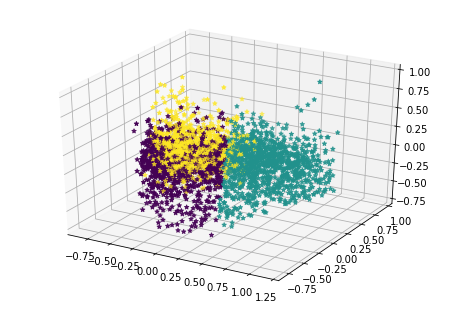

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:248: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


时段分配： [253.8833663144133, 576.9470266265075, 1300.0]
7.1539956641356754
选取片段: 3
单段时长 304


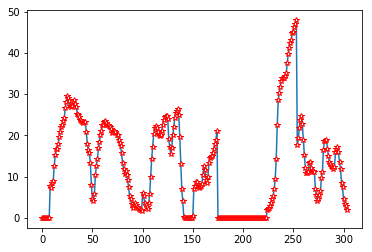

5.734977877116352
选取片段: 4
单段时长 276


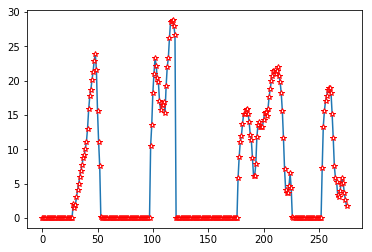

6.417512095619237
选取片段: 5
单段时长 763


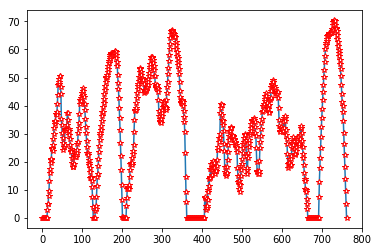

工况总长 1343
完整工况图：


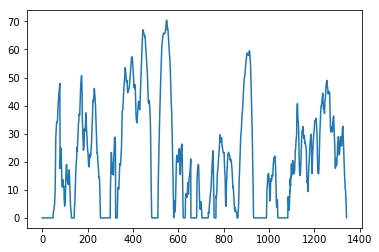

T             111.916667
Ta             39.750000
Td             33.166667
Tc             46.833333
Ti             26.333333
S             662.703704
Vmax           41.175000
Vm             18.764273
Vmr            24.322732
Vsd           206.821977
Amax            1.803241
Amin            1.587963
Aa              0.523889
Ad              0.587024
Asd             0.272097
Pi              0.286871
Pa              0.342338
Pd              0.270058
Pc              0.382072
P10             0.137109
P20             0.178687
P30             0.153606
P40             0.075616
P50             0.070223
P60             0.061542
P70             0.033768
P80             0.002577
P90             0.000000
A1              0.313040
A2              0.025440
A3              0.003857
A4              0.000000
A5              0.000000
A_1             0.229172
A_2             0.037650
A_3             0.003236
A_4             0.000000
A_5             0.000000
A_6             0.000000
Fuel_sum     1432.086250


In [69]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.cluster import KMeans  
import matplotlib.pyplot as plt 
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

class Models():
    def __init__(self):
        self.frag_path='./cpic_data/frag/'
        self.data_path='./cpic_data/'
        
    def Kmeans_Model(self,train_data):
#         model_data=pd.read_csv(self.frag_path+data_file)
#         model_data2=pd.read_csv(self.frag_path+'frag_feature_2.csv')
#         model_data3=pd.read_csv(self.frag_path+'frag_feature_3.csv')
#         model_data=pd.concat([model_data,model_data2,model_data3])
#         train_data=model_data[[x for x in model_data.columns if x not in ['begin_index','end_index',
#                                                                          'begin_time',
#                                                                          'end_time']]]
#         train_data=train_data.fillna(0)
        scores=[]
        scores_2=[]
        kmeans=KMeans(n_clusters=3)
        kmeans.fit(train_data)
        import numpy as np
        
      
        estimator = KMeans(n_clusters=3)  # 构造聚类器

        y = estimator.fit_predict(train_data)  # 聚类

        label_pred = estimator.labels_  # 获取聚类标签

        centroids = estimator.cluster_centers_  # 获取聚类中心

        print(label_pred)
        print(centroids)

        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(train_data[:, 0], train_data[:, 1], train_data[:, 2], c=y, marker='*')

        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='>')
        
        #plt.axis([0, 1, 0, 1])
        plt.show()
        # 轮廓系数计算
#         for t in range(2,10):
#             kmeans=KMeans(n_clusters=t)
#             kmeans.fit(train_data)
#             sc_score = silhouette_score(train_data, kmeans.labels_, metric = 'cosine')
#             scores.append(sc_score)
#             #sc_score_2 = silhouette_score(train_data, kmeans.labels_, metric = 'euclidean')
#             #scores_2.append(sc_score_2)
         
#         plt.figure()  
        
#         colors = ['b', 'g', 'r']  
#         markers = ['o', 's', 'D']  
#         plt.plot([x for x in range(2,10)],scores,'*-')
#         #plt.plot([x for x in range(2,10)],scores_2)
#         plt.show()  
        return kmeans.labels_
    
    
    def PCA_Model(self):
        model_data=pd.read_csv(self.frag_path+'v3_frag_feature_1.csv')
        model_data2=pd.read_csv(self.frag_path+'v3_frag_feature_2.csv')
        model_data3=pd.read_csv(self.frag_path+'v3_frag_feature_3.csv')
        model_data=pd.concat([model_data,model_data2,model_data3])
        train_data=model_data[[x for x in model_data.columns if x not in ['flag','begin_index','end_index',
                                                                         'begin_time',
                                                                         'end_time',
                                                                          'Fuel_sum',
                                                                         'Fuel_avg',
                                                                         'Fuel_avgr','P70','P80','P90','A5','A_5','A_6']]]
        
        #print(train_data.shape[0]-train_data.count())
        
        # 注： Ad减速度平均值 存在空缺值，
        
        #train_data=train_data.fillna(0)
        train_data=train_data.dropna()
        train_data = (train_data-train_data.min())/(train_data.max()-train_data.min())
        pca = PCA(n_components=10)
        
        pca.fit(train_data)
        new_data = pca.transform(train_data)
        #print(type(new_data))
        print(new_data[:,[0,1,2,3,4,5,6]])
        print('主成分贡献率',pca.explained_variance_ratio_)
        labels=self.Kmeans_Model(new_data[:,[0,1,2,3,4,5]])
        model_data=model_data.dropna()

        model_data['label']=labels
        model_data.to_csv(self.frag_path+'v3_kmeans_3c.csv',index=None)
        
    
  
    ### 回声状态网络
    ### https://blog.csdn.net/minemine999/article/details/80861863
    ### http://www.360doc.com/content/19/0326/21/32196507_824363531.shtml
    ### https://github.com/mrdragonbear/EchoStateNetworks/blob/master/Echo_State_Networks.ipynb
    
    def ESN_Model(self,data_file):
        pass
    
    ### 
    def get_directions(self,labels):
        #print(labels)
        tmp=''.join([str(x) for x in labels])
        print(tmp)
        res=[]
        for i in range(3):
            res.append([0,0,0])
        for k in range(3):
            for j in range(3):
                if k==j:
                    continue
                res[k][j]=tmp.count(str(k)+str(j))
                
                #[k][j]
                
    
        
        return res
    ### 相关性检验
    def xy_conv():
        pass
    
    ### 序列划分计算
    def Time_Series_Model(self,time_file):
        data=pd.read_csv(self.frag_path+time_file,encoding='utf8')
        data['begin_time']=pd.to_datetime(data['begin_time'])
        data['end_time']=pd.to_datetime(data['end_time'])
        flag=False
        last_index=0
        last_time=0
        np_res=np.array([[0,0,0],
                        [0,0,0],
                        [0,0,0]])
        for _,row in data.iterrows():
            if not flag:
                flag=True
                last_index=_
                last_time=row['end_time']
                continue
            if (row['begin_time']-last_time).seconds>300:
                #print(row['begin_time'],last_time)
                #print(last_index,_)
                res=self.get_directions(data.iloc[last_index:_]['label'].tolist())
                last_index=_
                np_res=np_res+np.array(res)    
            last_time=row['end_time']
        #print(data['label'].tolist().count(0))
        labels_num=[]
        print(np_res)
        print(np_res[1,2])
        for i in range(3):
            labels_num.append(data['label'].tolist().count(i))
        labels_sum=[]
        for i in range(3):
            _sum=0
            
            for j in range(3):
                _sum+=np_res[j,i]/labels_num[j]
            labels_sum.append(_sum)
        #print(labels_sum)
        print('时段区间参考')
        print([x/sum(labels_sum) for x in labels_sum])
        print([1200*x/sum(labels_sum) for x in labels_sum])
        print([1300*x/sum(labels_sum) for x in labels_sum])
        
    ### 计算每个类别/状态的综合特征
    def State_Avg_Feature(self):
        data=pd.read_csv(self.frag_path+'v3_kmeans_3c.csv')
        T_sum=data.groupby(['label'])['T'].agg({'T_sum':'sum'})
        S_sum=data.groupby(['label'])['S'].agg({'S_sum':'sum'})
        Ti_sum=data.groupby(['label'])['Ti'].agg({'Ti_sum':'sum'})
        Tc_sum=data.groupby(['label'])['Tc'].agg({'Tc_sum':'sum'})
        Td_sum=data.groupby(['label'])['Td'].agg({'Td_sum':'sum'})
        Ta_sum=data.groupby(['label'])['Ta'].agg({'Ta_sum':'sum'})
        V_max=data.groupby(['label'])['Vmax'].agg({'V_max':'max'})
        Vm_m=data.groupby(['label'])['Vm'].agg({'Vm_m':'mean'})
        Vm_mr=data.groupby(['label'])['Vmr'].agg({'Vm_mr':'mean'})
        Vsd_m=data.groupby(['label'])['Vsd'].agg({'Vsd_m':'mean'})
        Aa_m=data.groupby(['label'])['Aa'].agg({'Aa_m':'mean'})
        A_max=data.groupby(['label'])['Amax'].agg({'A_max':'max'})
        Ad_m=data.groupby(['label'])['Ad'].agg({'Ad_m':'mean'})
        A_min=data.groupby(['label'])['Amin'].agg({'A_min':'max'})
        Asd_m=data.groupby(['label'])['Asd'].agg({'Asd_m':'mean'})
        Fuel_sum=data.groupby(['label'])['Fuel_sum'].agg({'Fuel_sum':'sum'})
        Fuel_avgm=data.groupby(['label'])['Fuel_avg'].agg({'Fuel_avgm':'mean'})
        
        self.feature= pd.concat([T_sum,
                                 Ti_sum,
                                 Tc_sum,
                                 Td_sum,
                                 Ta_sum,
                                 S_sum,
                                 V_max,Vm_m,Vm_mr,Vsd_m,
                                 Aa_m,A_max,Ad_m,A_min,Asd_m,
                                 Fuel_sum,Fuel_avgm
                                 
                                ],
                                axis=1,
                                join_axes=[T_sum.index])
            
        self.feature.to_csv(self.frag_path+'frags_3k_center.csv',index=None)
        
        
        
#         for i in range(state_num):
        
#             pass
            
    # 抽取代表性工况片段  
    # 0
    # 1
    # 2
    '''
       [474.9053627454215, 384.1385827016099, 340.95605455296874]
       [514.4808096408733, 416.1501312600774, 369.3690590990495]
       
[343.15992037548807, 392.7739739305034, 464.0661056940086]
[371.75658040677877, 425.5051384247121, 502.7382811685092]
    
    [445.1933413004954, 399.05654241415516, 455.7501162853495]

    '''
    def Extract_Frag(self,data_file):
        data=pd.read_csv(self.frag_path+data_file)
        tmp=data[[x for x in data.columns if x not in ['flag','begin_index','end_index',
                                                                         'begin_time',
                                                                         'end_time',
                                                                          'Fuel_sum',
                                                                         'Fuel_avg',
                                                                         'Fuel_avgr',
                                                                          'P70','P80','P90','A5','A_5','A_6']]]
        frag_groups=tmp.groupby(['label'])
        time_thred=[445,844,1299]
        work_condition_times=0
        work_condition_df=pd.DataFrame()
        work_condition_feature=pd.DataFrame()
        T_sum=tmp.groupby(['label'])['T'].agg({'T_sum':'sum'})
        time_thr_=[1300*x/sum(T_sum['T_sum'].tolist()) for x in T_sum['T_sum'].tolist()]
        time_thred=[time_thr_[0],time_thr_[0]+time_thr_[1],sum(time_thr_)]
        print('时段分配：',time_thred)
        for _label,frags in frag_groups:
            #1. 归一化操作
            frags=frags[[x for x in frags.columns if x not in ['label']]]
            frags=(frags-frags.min())/(frags.max()-frags.min())
            
            #2. 计算特征平均值之和
            feature_std=frags.mean().sum()
            print(feature_std)
            frags['Col_sum'] = frags.apply(lambda x: x.sum(), axis=1)
            #print(frags['Col_sum'])
            tmp=(frags['Col_sum']-feature_std).abs()
            _inx=tmp.sort_values().head(6).index
            _frags=data.iloc[_inx]
            add_flag=False
            n=0
            for i in range(1,7):
                if data.iloc[_inx[:i]]['T'].sum()+work_condition_times<time_thred[_label]:
                    n+=1
                    continue
                else:
#                     pass
#                     #if work_condition_times>time_thred[]:
                        
                    if data.iloc[_inx[:i]]['T'].sum()+work_condition_times-time_thred[_label]<160 and not add_flag:
                        n+=1
                        add_flag=True
                    #print(data.iloc[_inx[:i]]['T'].sum()-time_thred[_label])
                    
                    
                    break
            print('选取片段:',n)
            _times=data.iloc[_inx[:n]]['T'].sum()
            work_condition_times+=_times
            print('单段时长',_times)
            work_condition_feature=work_condition_feature.append(data.iloc[_inx[:n]])
            work_condition_df=work_condition_df.append(self.Get_Raw_Frag(data.iloc[_inx[:n]]))
            
        print('工况总长',work_condition_times)
        print('完整工况图：')
        
        work_condition_df.sort_values(['format_time'],inplace=True)
        ms=[x for x in range(work_condition_df.shape[0])]           
        plt.plot(ms, work_condition_df['GPS车速'])
        plt.show()
        
        ### 总工况评估 work_condition_feature
        work_condition_feature=work_condition_feature[[x for x in data.columns if x not in ['flag','begin_index','end_index',
                                                                         'begin_time',
                                                                         'end_time','label'
                                                                          ]]]
        # 试验数据整体特征参数值
        data=data.drop_duplicates()
        raw_condition_feature=data[[x for x in data.columns if x not in ['flag','begin_index','end_index',
                                                                         'begin_time',
                                                                         'end_time','label'
                                                                          ]]]
        work_m=work_condition_feature.mean()
        
        raw_m=raw_condition_feature.mean()
        print(work_m,raw_m)
        print('偏差比')
        raw_m.to_csv(self.frag_path+'0922_kmeans_rank_1.csv')
        work_m.to_csv(self.frag_path+'0922_kmeans_rank_2.csv')
        print((work_m-raw_m).abs()/raw_m)
        res_p=(work_m-raw_m).abs()/raw_m
        res_p.to_csv(self.frag_path+'0922_kmeans_rank.csv')
        
    ### 根据索引提取原始数据片段
    def Get_Raw_Frag(self,frags):
        #print(frags)
        data_1=pd.read_csv(self.data_path+'del_acc_del_jam_long_filling_data_1.csv')
        data_2=pd.read_csv(self.data_path+'del_acc_del_jam_long_filling_data_2.csv')
        data_3=pd.read_csv(self.data_path+'del_acc_del_jam_long_filling_data_3.csv')
        res=pd.DataFrame()
        for _,row in frags.iterrows():
            if row['flag']==1:
                data=data_1
            elif row['flag']==2:
                data=data_2
            else:
                data=data_3
            #print(row['begin_index'],row['end_index'])
            res=res.append(data.iloc[row['begin_index']:row['end_index']])
        #print(res)
        
        ms=[x for x in range(res.shape[0])]
                    
        plt.plot(ms, res['GPS车速'], marker='*', mec='r', mfc='w')
        plt.show()
        return res
            

models=Models()
models.PCA_Model()
#models.State_Avg_Feature()

#models.Kmeans_Model('frag_feature_1.csv')
#models.Time_Series_Model('v3_kmeans_3c.csv')  
models.Extract_Frag('v3_kmeans_3c.csv')  

In [12]:

s="I am chinese"
x=s.split( )
a=0
i=" "
l=" "
for i in x:
    print (i)
    n=len(i)
    if n>a:
        l=i
        a=n
    

I
am
chinese


## 元片段模型
- 基于第二问所获得的运动学片段，进行元片段划分，每个元片段仅包含一种运动状态：**怠速、匀速、加速、减速**

1897.9400637658375


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:522: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


     flag  begin_index  end_index           begin_time             end_time  \
518     1        94640      94789  2017-12-21 15:32:34  2017-12-21 15:35:02   

       T  Ta  Td  Tc  Ti  ...         A_1       A_2  A_3  A_4  A_5  A_6  \
518  149  52  42  74  24  ...    0.228188  0.053691  0.0  0.0  0.0  0.0   

     Fuel_sum   Fuel_avg  Fuel_avgr  label  
518   2072.41  13.908792  13.908792      1  

[1 rows x 48 columns]


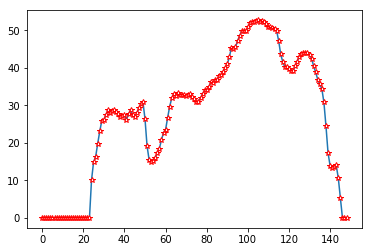

2


In [62]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.cluster import KMeans  
import matplotlib.pyplot as plt 
import numpy as np
import random
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 
class Unit_Models():
    def __init__(self):
        self.frag_path='./cpic_data/frag/'
        self.data_path='./cpic_data/'
        self.trans_matrix=0
        pass
    
    '''
    - 元单元划分模型
    输入： 运动学片段索引文件
    输出： 元单元片段索引文件
    
    怠速 ： unit_label - 0
    
    加速 ： unit_label - 1
    
    减速 ： unit_label - 2
    
    匀速 ： unit_label - 3
    
    '''
    
    def Unit_Split_Model(self,frag_file,data_file,flag):
        frag_data=pd.read_csv(self.frag_path+frag_file)
        raw_data=pd.read_csv(self.data_path+data_file)
        raw_data['format_time']=pd.to_datetime(raw_data['format_time'])
        unit_features=pd.DataFrame()
        for _,row in frag_data.iterrows():
            begin_index=row[1]
            end_index=row[0]
            frags_df=raw_data.iloc[begin_index:end_index]
            Ti=frags_df[(frags_df['GPS车速']==0)&(frags_df['acc_speed']==0)]
            unit_features=unit_features.append(self.Unit_Feature_Extract(Ti,raw_data,flag,0))
            Tc=frags_df[(frags_df['acc_speed']<=0.1)&(frags_df['GPS车速']!=0)&(frags_df['acc_speed']>=-0.1)]
            Ta=frags_df[frags_df['acc_speed']>0.1]
            Td=frags_df[frags_df['acc_speed']<-0.1]
            #print(Ti,Ta)
            unit_features=unit_features.append(self.Unit_Feature_Extract(Ta,raw_data,flag,1))
            
            unit_features=unit_features.append(self.Unit_Feature_Extract(Td,raw_data,flag,2))
            #print(Tc)
            unit_features=unit_features.append(self.Unit_Feature_Extract(Tc,raw_data,flag,3))
        unit_features.to_csv(self.frag_path+'unit_features_{}.csv'.format(flag),index=None)
        
#             y=frags_df['GPS车速'].tolist()
#             x=[_i for _i in range(len(y))]
#             plt.plot(x,y)
#             plt.show()
            
    def Get_Raw_Frag(self,frags):
        #print(frags)
        data_1=pd.read_csv(self.data_path+'del_acc_del_jam_long_filling_data_1.csv')
        data_2=pd.read_csv(self.data_path+'del_acc_del_jam_long_filling_data_2.csv')
        data_3=pd.read_csv(self.data_path+'del_acc_del_jam_long_filling_data_3.csv')
        res=pd.DataFrame()
        for _,row in frags.iterrows():
            if row['flag']==1:
                data=data_1
            elif row['flag']==2:
                data=data_2
            else:
                data=data_3
            #print(row['begin_index'],row['end_index'])
            res=res.append(data.iloc[row['begin_index']:row['end_index']])
        #print(res)
        
        ms=[x for x in range(res.shape[0])]
                    
        plt.plot(ms, res['GPS车速'], marker='*', mec='r', mfc='w')
        plt.show()
        return res
    
    def cal_unit_frag_features(self,unit_frags,data,flag,unit_label):
        #data=pd.read_csv(self.data_path+data_file)
        #frags=pd.read_csv(self.frag_path+frags_file)
        
        ### 运动时间
        feature_T=[]
        
        ### 加速时间
        feature_Ta=[]
        
        ### 减速时间
        feature_Td=[]
        
        ### 匀速时间
        feature_Tc=[]
        
        ### 怠速时间=[]
        feature_Ti=[]
        
        ### 运行距离  m
        feature_S=[]
        
        ### 运行最大速度=[]
        feature_Vmax=[]
        
        ### 运行平均速度=[] kM/h
        feature_Vm=[]
        
        ### 运行整体速度 km/h
        feature_Vmr=[]
        
        ### 运行速度标准方差
        feature_Vsd=[]
        
        ### 最大加速度
        feature_Amax=[]
        
        ### 加速段平均加速度
        feature_Aa=[]
        
        ### 最大减速度
        feature_Amin=[]
        
        ### 减速段平均减速度
        feature_Ad=[]
        
        ### 加速度标准偏差
        feature_Asd=[]
        
        ### 统计特征
        ###怠速时间比
        feature_Pi=[]
        
        ###加速时间比
        feature_Pa=[]
        
        ### 减速时间比
        feature_Pd=[]
        
        ###匀速时间比
        feature_Pc=[]
        
        ### 不同速度段占比
        feature_P10=[]
        feature_P20=[]
        feature_P30=[]
        feature_P40=[]
        feature_P50=[]
        feature_P60=[]
        feature_P70=[]
        feature_P80=[]
        ## 速度大于等于80 的项
        feature_P90=[]
        
        ### 不同加速段占比
        feature_A1=[]
        feature_A2=[]
        feature_A3=[]
        feature_A4=[]
        feature_A5=[]
        #加速度大于等于5
        
        feature_A_1=[]
        feature_A_2=[]
        feature_A_3=[]
        feature_A_4=[]
        feature_A_5=[]
        feature_A_6=[]
        
        ### 油耗信息
        feature_Fuel_sum=[]
        feature_Fuel_avg=[]
        feature_Fuel_avgr=[]
        
        ### 首末索引
        feature_begin_index=[]
        feature_end_index=[]
        feature_begin_time=[]
        feature_end_time=[]
        feature_flag=[]
        feature_unit_label=[]
        
        #frags.sort_values([frags.columns[0]],inplace=True)
      
        
        for (_min,_max) in unit_frags:
       
            #print(_min,_max)
            feature_flag.append(flag)
            feature_unit_label.append(unit_label)
            frag_cell=data.iloc[_min:_max]
            #print(frag_cell)
            feature_begin_index.append(_min)
            feature_end_index.append(_max)
            feature_begin_time.append(frag_cell.loc[_min,'format_time'])
            feature_end_time.append(frag_cell.loc[_max-1,'format_time'])
            T=frag_cell.shape[0]
            Ti=frag_cell[frag_cell['GPS车速']==0].shape[0]
            Ta=frag_cell[frag_cell['acc_speed']>0.1].shape[0]
            Td=frag_cell[frag_cell['acc_speed']<-0.1].shape[0]
            Tc=frag_cell[(frag_cell['acc_speed']<=0.1)&(frag_cell['GPS车速']>0)].shape[0]
            feature_T.append(T)
            feature_Ta.append(Ta)
            feature_Td.append(Td)
            feature_Tc.append(Tc)
            feature_Ti.append(Ti)
            
            ### 油耗信息
            feature_Fuel_sum.append(frag_cell['瞬时油耗'].sum())
            feature_Fuel_avg.append(frag_cell['瞬时油耗'].mean())
            feature_Fuel_avgr.append(frag_cell[frag_cell['瞬时油耗']>0]['瞬时油耗'].mean())
            
            
            feature_P10.append(frag_cell[(frag_cell['GPS车速']>0)&(frag_cell['GPS车速']<=10)].shape[0]/T)
            feature_P20.append(frag_cell[(frag_cell['GPS车速']>10)&(frag_cell['GPS车速']<=20)].shape[0]/T)
            feature_P30.append(frag_cell[(frag_cell['GPS车速']>20)&(frag_cell['GPS车速']<=30)].shape[0]/T)
            feature_P40.append(frag_cell[(frag_cell['GPS车速']>30)&(frag_cell['GPS车速']<=40)].shape[0]/T)
            feature_P50.append(frag_cell[(frag_cell['GPS车速']>40)&(frag_cell['GPS车速']<=50)].shape[0]/T)
            feature_P60.append(frag_cell[(frag_cell['GPS车速']>50)&(frag_cell['GPS车速']<=60)].shape[0]/T)
            feature_P70.append(frag_cell[(frag_cell['GPS车速']>60)&(frag_cell['GPS车速']<=70)].shape[0]/T)
            feature_P80.append(frag_cell[(frag_cell['GPS车速']>70)&(frag_cell['GPS车速']<=80)].shape[0]/T)
            feature_P90.append(frag_cell[frag_cell['GPS车速']>80].shape[0]/T)
            
            feature_A1.append(frag_cell[(frag_cell['acc_speed']>0.1)&(frag_cell['acc_speed']<=1)].shape[0]/T)
            feature_A2.append(frag_cell[(frag_cell['acc_speed']>1)&(frag_cell['acc_speed']<=2)].shape[0]/T)
            feature_A3.append(frag_cell[(frag_cell['acc_speed']>2)&(frag_cell['acc_speed']<=3)].shape[0]/T)
            feature_A4.append(frag_cell[(frag_cell['acc_speed']>3)&(frag_cell['acc_speed']<=4)].shape[0]/T)
            feature_A5.append(frag_cell[frag_cell['acc_speed']>4].shape[0]/T)
            
            feature_A_1.append(frag_cell[(frag_cell['acc_speed']<-0.1)&(frag_cell['acc_speed']>=-1)].shape[0]/T)
            feature_A_2.append(frag_cell[(frag_cell['acc_speed']<-1)&(frag_cell['acc_speed']>=-2)].shape[0]/T)
            feature_A_3.append(frag_cell[(frag_cell['acc_speed']<-2)&(frag_cell['acc_speed']>=-3)].shape[0]/T)
            feature_A_4.append(frag_cell[(frag_cell['acc_speed']<-3)&(frag_cell['acc_speed']>=-4)].shape[0]/T)
            feature_A_5.append(frag_cell[(frag_cell['acc_speed']<-4)&(frag_cell['acc_speed']>=-5)].shape[0]/T)
            feature_A_6.append(frag_cell[frag_cell['acc_speed']<-5].shape[0]/T)
            
            
            feature_Pi.append(Ti/T)
            feature_Pa.append(Ta/T)
            feature_Pd.append(Td/T)
            feature_Pc.append(Tc/T)
            feature_S.append(frag_cell['GPS车速'].sum()*1000/3600)
            feature_Vmax.append(frag_cell['GPS车速'].max())
            feature_Vm.append(frag_cell['GPS车速'].mean())
            feature_Vmr.append(frag_cell[frag_cell['GPS车速']>0]['GPS车速'].mean())
            feature_Vsd.append(frag_cell['GPS车速'].var())
            feature_Amax.append(frag_cell['acc_speed'].max())
            feature_Amin.append(-frag_cell['acc_speed'].min())
            feature_Aa.append(frag_cell[frag_cell['acc_speed']>0.1]['acc_speed'].mean())
            feature_Ad.append(-frag_cell[frag_cell['acc_speed']<-0.1]['acc_speed'].mean())
            feature_Asd.append(frag_cell['acc_speed'].var())
        frags_features=pd.DataFrame()
        frags_features['flag']=feature_flag
        frags_features['unit_label']=feature_unit_label
        frags_features['begin_index']=feature_begin_index
        frags_features['end_index']=feature_end_index
        frags_features['begin_time']=feature_begin_time
        frags_features['end_time']=feature_end_time
        # 基础物理学特征参数 14
        frags_features['T']=feature_T
        frags_features['Ta']=feature_Ta
        frags_features['Td']=feature_Td
        frags_features['Tc']=feature_Tc
        frags_features['Ti']=feature_Ti
        frags_features['S']=feature_S
        frags_features['Vmax']=feature_Vmax
        frags_features['Vm']=feature_Vm
        frags_features['Vmr']=feature_Vmr
        frags_features['Vsd']=feature_Vsd
        frags_features['Amax']=feature_Amax
        frags_features['Amin']=feature_Amin
        frags_features['Aa']=feature_Aa
        frags_features['Ad']=feature_Ad
        frags_features['Asd']=feature_Asd
        
        ### 基本统计分布特征 4 + 9 +11 
        frags_features['Pi']=feature_Pi
        frags_features['Pa']=feature_Pa
        frags_features['Pd']=feature_Pd
        frags_features['Pc']=feature_Pc
        
        frags_features['P10']=feature_P10
        frags_features['P20']=feature_P20
        frags_features['P30']=feature_P30
        frags_features['P40']=feature_P40
        frags_features['P50']=feature_P50
        frags_features['P60']=feature_P60
        frags_features['P70']=feature_P70
        frags_features['P80']=feature_P80
        frags_features['P90']=feature_P90
        
        frags_features['A1']=feature_A1
        frags_features['A2']=feature_A2
        frags_features['A3']=feature_A3
        frags_features['A4']=feature_A4
        frags_features['A5']=feature_A5
        
        frags_features['A_1']=feature_A_1
        frags_features['A_2']=feature_A_2
        frags_features['A_3']=feature_A_3                
        frags_features['A_4']=feature_A_4
        frags_features['A_5']=feature_A_5
        frags_features['A_6']=feature_A_6
        
        frags_features['Fuel_sum']=feature_Fuel_sum
        frags_features['Fuel_avg']=feature_Fuel_avg
        frags_features['Fuel_avgr']=feature_Fuel_avgr
        
        
        
        
        return frags_features
        
                    

    '''
    对同一单元集进行处理
    
    分割得到元片段，并进行特征计算
    
    怠速 ： unit_label - 0
    
    加速 ： unit_label - 1
    
    减速 ： unit_label - 2
    
    匀速 ： unit_label - 3
    
    '''
    def Unit_Feature_Extract(self,unit_df,data_df,flag,unit_label):
        
        begin_flag=False
        time_rsp=0
        last_index=0
        unit_frags=[]
        #print(unit_df['format_time'])
        #data_df['format_time']=pd.to_datetime(data_df['format_time'])
        no_more_units=False
        if len(unit_df)==0:
            return None
        ### 匀速情况特殊处理
        
        #kmeans=KMeans(n_clusters=2)
        unit_Feature=pd.DataFrame()
        for _,row in unit_df.iterrows():
            if not begin_flag:
                begin_flag=True
                time_rsp=row['format_time']
                last_index=_
                continue
            else:
                if (row['format_time']-time_rsp).seconds>1:
                    no_more_units=True
                    #片段长度控制
                    if _-last_index>10:
                        unit_frags.append((last_index,_))
                    last_index=_
                
                time_rsp=row['format_time']
                
        if not no_more_units:
            if _+1-last_index>10:
                unit_frags.append((last_index,_+1))
        #print(unit_frags)
        if len(unit_frags)==0:
            return None
        feature=self.cal_unit_frag_features(unit_frags,data_df,flag,unit_label)
        #unit_Feature=unit_Feature.append(feature)
        return feature
        
        #print(feature)
                #last_index=_
            
    
    '''
    元片段速度情况
    
    Vm <= 10: 2098
    Vm 10 <= 20: 3688
    Vm 20 <= 30: 4169
    Vm 30 <= 40: 3900
    Vm 40 <= 50: 2777
    Vm > 50: 3162
    
    Vm <= 10: 2098
Vm 10 <= 20: 3688
Vm 20 <= 30: 4169
Vm 30 <= 40: 3900
Vm 40 <= 50: 2777
Vm 50 <= 60: 1605
Vm > 60: 1557

    '''
    def Unit_Speed_Analy(self,unit_file):
        unit_df=pd.read_csv(self.frag_path+unit_file)
        print('Vm <= 10:',unit_df[unit_df['Vm']<=10].shape[0])
        print('Vm 10 <= 20:',unit_df[(unit_df['Vm']>10)&(unit_df['Vm']<=20)].shape[0])
        print('Vm 20 <= 30:',unit_df[(unit_df['Vm']>20)&(unit_df['Vm']<=30)].shape[0])
        print('Vm 30 <= 40:',unit_df[(unit_df['Vm']>30)&(unit_df['Vm']<=40)].shape[0])
        print('Vm 40 <= 50:',unit_df[(unit_df['Vm']>40)&(unit_df['Vm']<=50)].shape[0])
        
        print('Vm 50 <= 60:',unit_df[(unit_df['Vm']>50)&(unit_df['Vm']<=60)].shape[0])
        print('Vm > 60:',unit_df[unit_df['Vm']>60].shape[0])
        
    
    '''
    增添元片段状态标记
    0-6
    '''
    def state_label(self,cell):
        if cell<=10:
            return 0
        if cell<=20:
            return 1
        if cell<=30:
            return 2
        if cell<=40:
            return 3
        if cell<=50:
            return 4
        if cell<=60:
            return 5
        return 6
    
    '''
    元片段数量及状态量
(33063, 49)
2    6903
3    5956
0    5332
1    5265
4    4090
6    3305
5    2212
    '''
    def Add_Unit_label(self):
        unit_1=pd.read_csv(self.frag_path+'unit_features_1.csv')
        unit_2=pd.read_csv(self.frag_path+'unit_features_2.csv')
        unit_3=pd.read_csv(self.frag_path+'unit_features_3.csv')
        units=pd.concat([unit_1,unit_2,unit_3],axis=0)
        units['unit_state']=units['Vm'].apply(self.state_label)
        print(units.shape)
        units.to_csv(self.frag_path+'units_state7.csv',index=None,encoding='utf8')
        print(units['unit_state'].value_counts())
        
        #pass
    

     ### 
    def get_directions(self,states):
        res=np.zeros((7,7))
        for i in range(1,len(states)):
            res[states[i-1],states[i]]+=1  
                #[k][j]  
        return res
  
    '''
    马尔可夫状态转移概率矩阵计算
    输入： units_state7
    
    '''
    def Markov_Trans_Matrix(self,state_file='units_state7.csv'):
        data=pd.read_csv(self.frag_path+state_file,encoding='utf8')
        data['begin_time']=pd.to_datetime(data['begin_time'])
        data['end_time']=pd.to_datetime(data['end_time'])
        flag=False
        last_index=0
        last_time=0
        ### 转移数量矩阵
        np_res=np.zeros((7,7))
        ### 转移概率矩阵
        np_prob=np.zeros((7,7))
        for _,row in data.iterrows():
            if not flag:
                flag=True
                last_index=_
                last_time=row['end_time']
                continue
            
            # 找到最长有效连续时间段
            
            if (row['begin_time']-last_time).seconds>300:
                #print(row['begin_time'],last_time)
                #print(last_index,_)
                res=self.get_directions(data.iloc[last_index:_]['unit_state'].tolist())
                last_index=_
                np_res=np_res+np.array(res)    
            last_time=row['end_time']
        if _-last_index>10:
            res=self.get_directions(data.iloc[last_index:_]['unit_state'].tolist())
            np_res=np_res+np.array(res)    
        #print(data['label'].tolist().count(0))
        labels_num=[]
        print(np_res)
        # 计算概率矩阵
        np_prob=np_res/np_res.sum(axis=1)
        print(np_prob)
        self.trans_matrix=np_prob
        #print(np_res[1,2])
        
        
    
    '''
    马尔可夫方法 元片段选择与工况曲线构成
    
    '''
    def Markov_Extract_Unit(self):
        ###
        ### step_1. 选取最优起始片段
        frags_df=pd.read_csv(self.frag_path+'v3_kmeans_3c.csv')
        units_df=pd.read_csv(self.frag_path+'units_state7.csv')
        tmp=frags_df[[x for x in frags_df.columns if x not in ['label','flag','begin_index','end_index',
                                                                         'begin_time',
                                                                         'end_time',
                                                                          'Fuel_sum',
                                                                         'Fuel_avg',
                                                                         'Fuel_avgr']]]
        
        feature_std=tmp.mean().sum()
        
        print(feature_std)
        
        tmp['Col_sum'] = tmp.apply(lambda x: x.sum(), axis=1)
        #print(frags['Col_sum'])
        delta_tmp=(tmp['Col_sum']-feature_std).abs()
        best_frag_index=delta_tmp.sort_values().head(1).index
        #_frags=data.iloc[_inx]
        best_frag=frags_df.iloc[best_frag_index]
        print(best_frag)
        self.Get_Raw_Frag(best_frag)
        
        ### step_2  最优运动学片段的最后一个元片段状态：
        
        best_frag_begin_index=best_frag['begin_index'].tolist()[0]
        best_frag_end_index=best_frag['end_index'].tolist()[0]
        best_frag_data_flag=best_frag['flag'].tolist()[0]
        markov_init_unit=units_df[(units_df['begin_index']>=best_frag_begin_index)&(units_df['flag']==best_frag_data_flag)&(units_df['begin_index']<=best_frag_end_index)]
        
        current_state=markov_init_unit.iloc[markov_init_unit.shape[0]-1]['unit_state']
        current_speed=markov_init_unit.iloc[markov_init_unit.shape[0]-1]['Vm']
        units_records=[]
        
        
        while True:
            next_state=self.trans_state(current_state)
            
            # 后选
            
            w_u_df=units_df[units_df['unit_state']==next_state]
            
        
        
        
        
        #break
        ### step_3 根据状态转移矩阵计算出后续元片段状态并从中选取最接近的
        
        pass
    
    def trans_state(self,state):
        prob=random.random()
        state_probs=list(self.trans_matrix[state,:])
        next_state=0
        probs_sum=[]
        tmp=0
        for i in range(state_probs):
            tmp+=i
            probs_sum.append(tmp)
        #if probs_sum>prob:
        for i in range(len(probs_sum)):
            if probs_sum[i]>prob:
                return i
        return next_state

units_model=Unit_Models()
#units_model.Add_Unit_label()
#units_model.Markov_Trans_Matrix()

units_model.Markov_Extract_Unit()

# units_model.Unit_Speed_Analy('unit_features_1.csv')
# units_model.Unit_Split_Model('v2_frag_data_1.csv','del_acc_del_jam_long_filling_data_1.csv',1)
# units_model.Unit_Split_Model('v2_frag_data_2.csv','del_acc_del_jam_long_filling_data_2.csv',2)
# units_model.Unit_Split_Model('v2_frag_data_3.csv','del_acc_del_jam_long_filling_data_3.csv',3)


## 模型检验
- 选取原始数据中两位特征 油耗  空燃比之类的  与其他运动学特征 一起进行模型误差检验

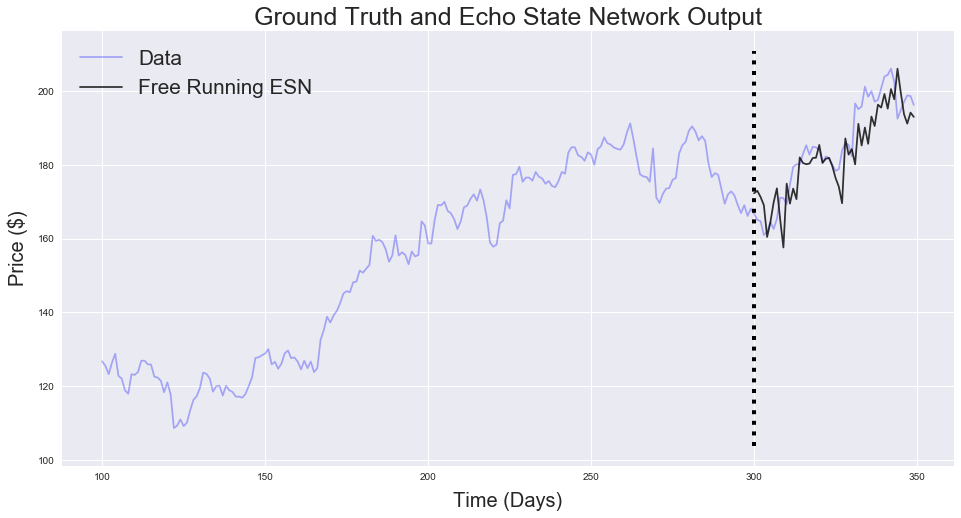

In [130]:
import pandas as pd
from pyESN import ESN
import seaborn as sns
from matplotlib import rc
data = open("./cpic_data/amazon.txt").read().split()
data = np.array(data).astype('float64')
n_reservoir= 500
sparsity=0.2
rand_seed=23
spectral_radius = 1.2
noise = .0005


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = 300
future = 2
futureTotal=50
pred_tot=np.zeros(futureTotal)

for i in range(0,futureTotal,future):
    pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
    prediction = esn.predict(np.ones(future))
    pred_tot[i:i+future] = prediction[:,0]
plt.figure(figsize=(16,8))
plt.plot(range(100,trainlen+futureTotal),data[100:trainlen+futureTotal],'b',label="Data", alpha=0.3)
#plt.plot(range(0,trainlen),pred_training,'.g',  alpha=0.3)
plt.plot(range(trainlen,trainlen+futureTotal),pred_tot,'k',  alpha=0.8, label='Free Running ESN')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Ground Truth and Echo State Network Output', fontsize=25)
plt.xlabel(r'Time (Days)', fontsize=20,labelpad=10)
plt.ylabel(r'Price ($)', fontsize=20,labelpad=10)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()
plt.show()